In [18]:
# # some imports
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
#
# # Python ≥3.5 is required
# import sys
# assert sys.version_info >= (3, 5)
#
# # Scikit-Learn ≥0.20 is required
# import sklearn
# assert sklearn.__version__ >= "0.20"
#
#
# # TensorFlow ≥2.0 is required
# import tensorflow as tf
# assert tf.__version__ >= "2.0"
#
#
# # Common imports
# import numpy as np
# import os
#
# # to make this notebook's output stable across runs
# np.random.seed(42)
#
# # To plot pretty figures
# %matplotlib inline
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)
# plt.rc('font', size=12)
# plt.rc('figure', figsize = (12, 5))
#
# # Settings for the visualizations
# #import seaborn as sns
# #sns.set_style("whitegrid")
# #sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})
#
# import pandas as pd
# pd.set_option('display.max_rows', 25)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.max_colwidth', 50)
#
# # Ignore useless warnings (see SciPy issue #5998)
# import warnings
# warnings.filterwarnings(action="ignore", message="^internal gelsd")
# Others
# import cv2
# import tqdm
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.applications.vgg16 import preprocess_input
# from sklearn.model_selection import train_test_split
# from skimage.io import imread
# from skimage.util import img_as_float

In [3]:
import os
import pandas as pd
import numpy as np
import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.util import img_as_float
import matplotlib.pyplot as plt

 ## Import data

In [4]:
# Paths
X_train_path = './dataset/train/train/train/'
X_test_path = './dataset/test/test/test/'
dataset_csv = './dataset/train.txt'
dataset_train = './dataset/train/train'
dataset_test = './dataset/test/test'

In [5]:
_STOP = 1000
def preprocess(img_paths,dataset_path,preprocess_img_method = None):
    print("loading data")
    data = []
    stop = 0
    for img_path in tqdm.tqdm(img_paths):
        path = os.path.realpath(os.path.join(dataset_path,img_path[1:]))
        img = imread(path)
        if preprocess_img_method:
            img = preprocess_img_method(img)
        else:
            # img = cv2.resize(img,(224,224),cv2.INTER_AREA)
            # img = img / 255. #normalize
            img = img_as_float(img)
        data.append(img)
        stop += 1
        if(stop == _STOP):
            break
    print("loading data done")
    return data

def preprocess_img_vgg(img):
    return preprocess_input(img)


In [6]:
df = pd.read_csv(dataset_csv, delimiter='\ ', header=None)
y_train_full = np.array(df[1])
img_paths = df[0]
X_train_full = preprocess(df[0], dataset_train,preprocess_img_method=None)
X_train_full= np.stack(X_train_full)

C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


loading data


  7%|▋         | 999/15000 [00:00<00:11, 1258.63it/s]

loading data done


In [7]:
print(max(y_train_full))

29


In [8]:
# Split dataset
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full[:_STOP], random_state=42)

In [7]:
print(X_train[0].shape)

(158, 158)


In [8]:
print(len(X_train))
print(len(y_train))
print(len(X_valid))
print(len(y_valid))

750
750
250
250


In [9]:
print(len(X_train))
print(X_train[0].shape)
print(type(X_train))
print(X_train.shape)
print(type(X_train[0]))

750
(158, 158)
<class 'numpy.ndarray'>
(750, 158, 158)
<class 'numpy.ndarray'>


[16 17  6 27 18 16 29 29  9 28]


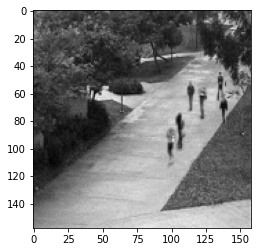

In [9]:
print(y_train[10:20])
plt.imshow(X_train[12], cmap='gray')

no_classes = max(y_train_full)

## Model

In [16]:
def init_weights_vgg(model):
    vgg =  tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False)

    vgg_weights=[]
    for layer in vgg.layers:
        if('conv' in layer.name):
            vgg_weights.append(layer.get_weights())


    offset=0
    i=0
    while(i<10):
        if('conv' in model.layers[i+offset].name):
            model.layers[i+offset].set_weights(vgg_weights[i])
            i=i+1
            #print('h')

        else:
            offset=offset+1

    return (model)

In [40]:
def CrowdNet():
    #Variable Input Size
    rows = 158
    cols = 158

    #Batch Normalisation option

    batch_norm = False
    kernel = (3, 3)
    init = tf.keras.initializers.RandomNormal(stddev=0.01)
    model = tf.keras.models.Sequential()

    #custom VGG:

    if(batch_norm):
        model.add(keras.layers.Conv2D(64, kernel_size = kernel, input_shape = (rows,cols),activation = 'relu', padding='same'))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same'))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.MaxPooling2D(strides=2))
        model.add(keras.layers.Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same'))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same'))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.MaxPooling2D(strides=2))
        model.add(keras.layers.Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.MaxPooling2D(strides=2))
        model.add(keras.layers.Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
        model.add(keras.layers.BatchNormalization())

    else:
        model.add(keras.layers.Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same',input_shape = (rows, cols, 3), kernel_initializer = init))
        model.add(keras.layers.Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
        model.add(keras.layers.MaxPooling2D(strides=2))
        model.add(keras.layers.Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
        model.add(keras.layers.Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
        model.add(keras.layers.MaxPooling2D(strides=2))
        model.add(keras.layers.Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
        model.add(keras.layers.Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
        model.add(keras.layers.Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
        model.add(keras.layers.MaxPooling2D(strides=2))
        model.add(keras.layers.Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
        model.add(keras.layers.Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
        model.add(keras.layers.Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))

    #Conv2D
    model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
    model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
    model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
    model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
    model.add(keras.layers.Conv2D(1, (1, 1), activation='relu', dilation_rate = 1, kernel_initializer = init, padding = 'same'))

    # model.add(keras.layers.Flatten())
    sgd = keras.optimizers.SGD(lr = 1e-7, decay = (5*1e-4), momentum = 0.95)
    model.compile(optimizer=sgd, loss='mse', metrics=['mse'])

    model = init_weights_vgg(model)

    return model

In [41]:
model=CrowdNet()
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_87 (Conv2D)           (None, 158, 158, 64)      1792      
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 158, 158, 64)      36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 79, 79, 64)        0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 79, 79, 128)       73856     
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 79, 79, 128)       147584    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 39, 39, 128)       0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 39, 39, 256)      

In [37]:
sgd = keras.optimizers.SGD(lr = 1e-2, decay = (5*1e-4), momentum = 0.95)
model.compile(optimizer=sgd, loss="mse", metrics=['mse'])



In [38]:
history = model.fit(x=X_train,y=y_train,epochs=2, verbose=1,validation_data=(X_valid, y_valid))

Epoch 1/2


ValueError: in user code:

    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:196 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential_7 is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: [None, 158, 158]


<AxesSubplot:>

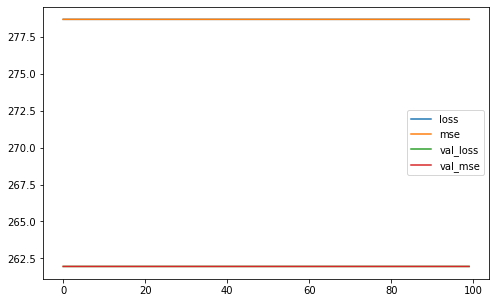

In [39]:
pd.DataFrame(history.history).plot(figsize=(8, 5))

